# Model Comprehension: Feature Attribution

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import io
from captum.attr import IntegratedGradients, Occlusion
from captum.attr import visualization as viz
import os, sys
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
sys.path.append(os.path.join(sys.path[0], ".."))

from configs import Configs
from ML_utils.model import get_model

In [2]:
img_id = 0
round_id = 90

## Intergrated Gradient

In [3]:
model = get_model(model_name=Configs.MODEL_NAME, device="cpu")
model_path = os.path.join("saved", "models", f"task_{Configs.TASK}", f"round_{round_id}.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

# trans_mnist = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])

trans_mnist = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])


img_path = os.path.join("saved", "images", f"task_{Configs.TASK}", f"{img_id}.png")
if Configs.TASK == 0:
    input_img  = io.read_image(img_path, mode=io.ImageReadMode.GRAY)
else:
    input_img = io.read_image(img_path)
# transformed_img = Transform_CUS[Config.TASK](input_img)
transformed_img = trans_mnist(input_img)
transformed_img = transformed_img.unsqueeze(0)
input_img = transformed_img

Using cache found in /home/rean/.cache/torch/hub/pytorch_vision_v0.10.0


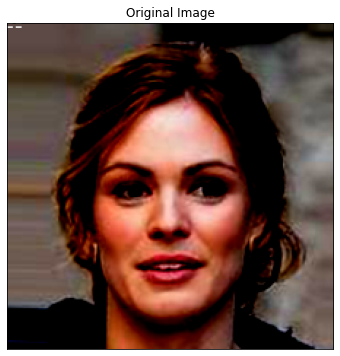

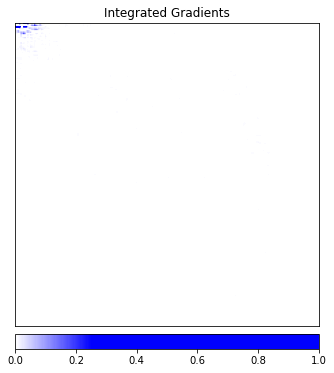

In [4]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(transformed_img, target=Configs.POISON_SWAP_LABEL, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

## Occlusion

/home/rean/miniconda3/envs/PEFL/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


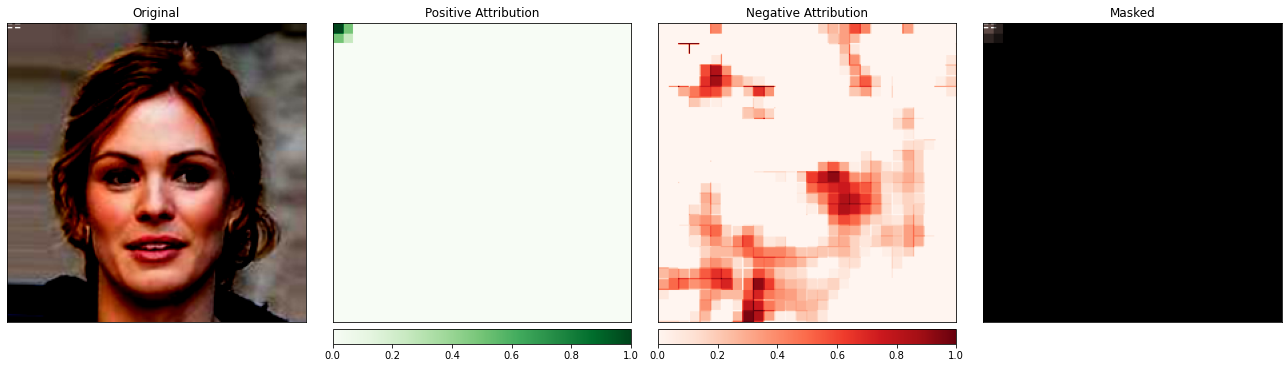

In [6]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(transformed_img,
                                       # target=0,
                                       target=Configs.POISON_SWAP_LABEL,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )